In [1]:
import pandas as pd
import numpy as np
import warnings 
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary

In [2]:
import sys
print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pyLDAvis
import pyLDAvis.gensim_models

In [4]:
from bs4 import BeautifulSoup

def remove_html_tags_code(text):
    soup = BeautifulSoup(text, 'html.parser')
    code_tags = soup.find_all('code')
    for code_tag in code_tags:
        code_tag.decompose()
    return soup.get_text()

In [5]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [6]:
def remove_stop_short_words(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words and len(word) > 2]
    return filtered_text

In [7]:
def filter_tokens(tokens, dictionary):
    return [token for token in tokens if token in dictionary.token2id]

In [8]:
def removed_word_frequency(nb_words, dictionary_before, dictionary_after):
# affichage des nb_words les moins fréquents , et les plus fréquents

# Get the words removed after filtering
    words_removed = set(dictionary_before.token2id.keys()) - set(dictionary_after.token2id.keys())

# Get the document frequencies of the removed words
    removed_word_dfs = [dictionary_before.dfs[dictionary_before.token2id[word]] for word in words_removed]

# Sort the removed words by their document frequency in descending order
    sorted_removed_words = sorted(zip(words_removed, removed_word_dfs), key=lambda x: x[1], reverse=False)
# Select the top nb_words removed words
    least_documents_words = sorted_removed_words[:nb_words]

# Extract the words and document frequencies for plotting
    words = [word for word, _ in least_documents_words]
    dfs = [df for _, df in least_documents_words]

# Create a bar chart of the top removed words
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), dfs)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Document Frequency')
    plt.ylabel('Words')
    plt.title('Top Least Frequent Words Removed')
    plt.show()

# Sort the removed words by their document frequency in descending order
    sorted_removed_words = sorted(zip(words_removed, removed_word_dfs), key=lambda x: x[1], reverse=True)
# Select the top nb_words removed words
    most_documents_words = sorted_removed_words[:nb_words]

# Extract the words and document frequencies for plotting
    words = [word for word, _ in most_documents_words]
    dfs = [df for _, df in most_documents_words]

# Create a bar chart of the top removed words
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), dfs)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Document Frequency')
    plt.ylabel('Words')
    plt.title('Top Most Frequent Words Removed')
    plt.show()
    
    reduction_ratio = len(dictionary_after) / len(dictionary_before)
    reduction_ratio = round(1-reduction_ratio, 2)  # Round the ratio to two decimal places
    print("nb mots avant = ",len(dictionary_before), "  nombre de mots après = ", len(dictionary_after), "ratio de réduction = ", reduction_ratio )
    return reduction_ratio

# Retrieve data  

SQL Query : 
SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts
WHERE PostTypeId = 1 AND Score >= 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [9]:
warnings.filterwarnings('ignore')

In [10]:
data =  pd.read_csv('QueryResults.csv',  engine = 'python',  on_bad_lines = 'skip', index_col=[0])

In [11]:
col = data.columns
col

Index(['Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount'],
      dtype='object')

In [12]:
data.reset_index(inplace=True)

In [13]:
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Access Denied when using Power Shell Remoting ...,<p>I want to remotely trigger some commands wi...,<windows><powershell><server><core><remoting>,54569222,2,2151,NaN,2
1,Preprocess SHPAML in Django's template loader?,<p>Is there any way to make Django's template ...,<python><django><templates><preprocessor><shpaml>,2131029,3,585,0.0,2
2,Writing eclipse templates,<p>I am writing django templates in Eclipse->p...,<django><eclipse><templates><eclipse-plugin><e...,2131039,7,554,0.0,1
3,Auto update and build with eclipse and SVN,<p>every morning when i come to work i update ...,<eclipse><svn><build-process><performance><sub...,2131045,2,1262,NaN,1
4,Use .NET in VB6 or classical ASP,"<p><strong>Duplicate of</strong> <a href=""http...",<.net><com><vb6><asp-classic><wrapper>,2131111,3,1548,0.0,3


# 1. Traitement des donnees

## 1.1 Analyse des données 

### 1.1.1  Réduction des variables numériques par ACP  

In [14]:
scores = ["Score","ViewCount","AnswerCount","FavoriteCount"]
data[scores].describe()

,Score,ViewCount,AnswerCount,FavoriteCount
count,50000.000000,5.000000e+04,50000.000000,16615.0
mean,7.165040,7.016561e+03,1.842580,0.0
std,96.430085,6.698717e+04,2.377358,0.0
min,0.000000,1.300000e+01,0.000000,0.0
25%,0.000000,2.710000e+02,1.000000,0.0
50%,1.000000,8.540000e+02,1.000000,0.0
75%,3.000000,2.515000e+03,2.000000,0.0
max,9350.000000,7.766370e+06,111.000000,0.0


FavoriteCount est vide, à éliminer

In [15]:
scores = ["Score","ViewCount","AnswerCount"]
data = data.drop('FavoriteCount', axis=1)

In [16]:
df = data[scores]

In [17]:
X = df.values

In [18]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [19]:
n = 3
pca = PCA(n_components=n)
pca.fit(X_scaled)
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()

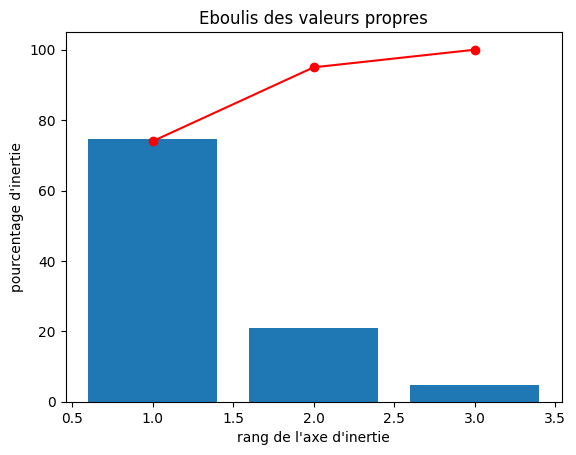

In [20]:
x_list = range(1, n+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [21]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.05,
                head_length=0.05, 
                width=0.01, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.03,
                pca.components_[y, i] + 0.03,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

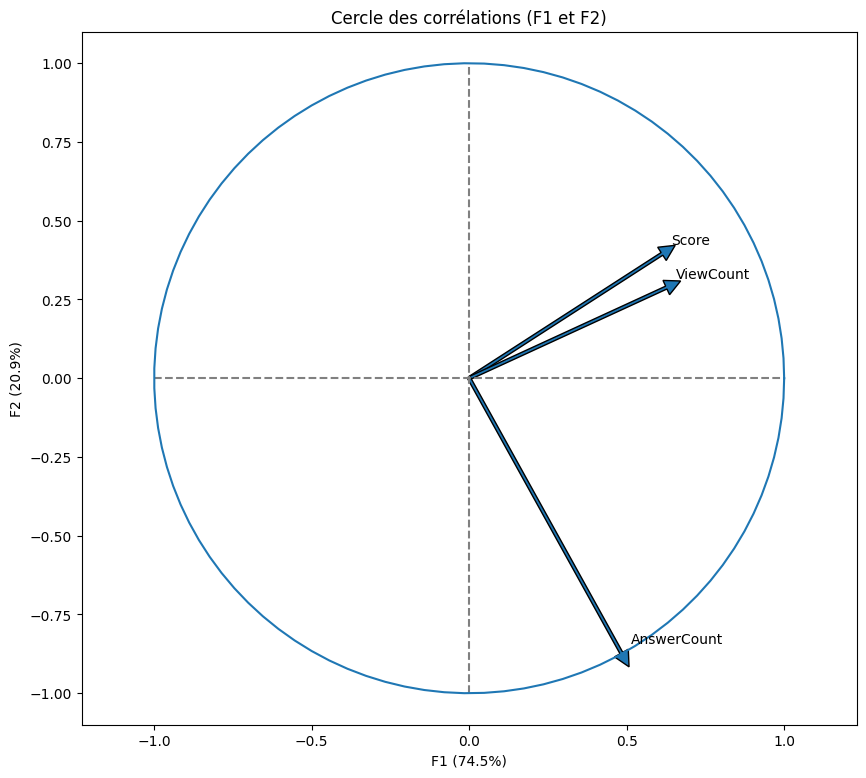

In [22]:
x_y = (0,1)
correlation_graph(pca, x_y, scores)

il y a une corrélation forte entre score et viewcount, supprimer viewcount

In [23]:
data = data.drop('ViewCount', axis=1)

### 1.1.2  Vérification valeurs invalides

verifie la valeur nulle ou négative

In [24]:
data[["Score","AnswerCount"]].isnull().sum().sum()

0

In [25]:
(data[["Score", "AnswerCount"]] < 0).sum().sum()

0

il y a une corrélation forte entre score et viewcount, supprimer viewcount

### 1.1.3  Chargement des données

In [26]:
corpus = data[['Id', 'Title', 'Body', 'Tags', 'Score', 'AnswerCount']].copy()

## 1.2 Traitements de title

### 1.2.1 Traitement de formattage

In [57]:
# Normalisation de la casse (mise en minuscules)
corpus['Title_process'] = corpus['Title'].str.lower()
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,access denied when using power shell remoting ...
1,Preprocess SHPAML in Django's template loader?,preprocess shpaml in django's template loader?
2,Writing eclipse templates,writing eclipse templates
3,Auto update and build with eclipse and SVN,auto update and build with eclipse and svn
4,Use .NET in VB6 or classical ASP,use .net in vb6 or classical asp


In [58]:
# Supprimer les caractères spéciaux  
# les caractères qui ne sont pas des lettres de l'alphabet (majuscules ou minuscules) y compris des chiffres sauf '-'
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,access denied when using power shell remoting ...
1,Preprocess SHPAML in Django's template loader?,preprocess shpaml in django s template loader
2,Writing eclipse templates,writing eclipse templates
3,Auto update and build with eclipse and SVN,auto update and build with eclipse and svn
4,Use .NET in VB6 or classical ASP,use net in vb or classical asp


In [59]:
# Tokenization (découpage en mots)
corpus['Title_process'] = corpus['Title_process'].apply(nltk.word_tokenize)
corpus[['Title', 'Title_process']].head(10)

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, when, using, power, shell, re..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, in, django, s, template, ..."
2,Writing eclipse templates,"[writing, eclipse, templates]"
3,Auto update and build with eclipse and SVN,"[auto, update, and, build, with, eclipse, and,..."
4,Use .NET in VB6 or classical ASP,"[use, net, in, vb, or, classical, asp]"
5,Having trouble getting Algolia Search to recog...,"[having, trouble, getting, algolia, search, to..."
6,Java client for REST web service with Netbeans,"[java, client, for, rest, web, service, with, ..."
7,Aurelia starting with params passed by PHP,"[aurelia, starting, with, params, passed, by, ..."
8,Mamp connect to a global sql database,"[mamp, connect, to, a, global, sql, database]"
9,Mahapp Metro Window Title not visible in TaskBar,"[mahapp, metro, window, title, not, visible, i..."


In [60]:
# Supprimer les mots non informatifs (stop words)
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: remove_stop_short_words(x))
corpus[['Title', 'Title_process']].head(5)

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, using, power, shell, remoting..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, django, template, loader]"
2,Writing eclipse templates,"[writing, eclipse, templates]"
3,Auto update and build with eclipse and SVN,"[auto, update, build, eclipse, svn]"
4,Use .NET in VB6 or classical ASP,"[use, net, classical, asp]"


In [61]:
# Lemmatisation
# We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer 
# in this case because we want contextual keyword and lemmatizer takes this into account, while stemmer doesn't.
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: lemmatize_text(x))
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, using, power, shell, remoting..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, django, template, loader]"
2,Writing eclipse templates,"[writing, eclipse, template]"
3,Auto update and build with eclipse and SVN,"[auto, update, build, eclipse, svn]"
4,Use .NET in VB6 or classical ASP,"[use, net, classical, asp]"


### 1.2.2 Réduction de dimensions par fréquence

In [62]:
# Réduction de tokens extrèmes,  les 100 tokens les plus fréquents et les tokens présents 
# dans moins de 3 documents sont supprimés

# Create the dictionary before filtering
dictionary_before = corpora.Dictionary(corpus['Title_process'])

# Create an empty dictionary
dictionary_after = corpora.Dictionary(corpus['Title_process'])

# Print the first 10 elements of the dictionary
for word_id, word in list(dictionary_after.items())[:10]:
    print(f"Word ID: {word_id}, Word: {word}")
    
# Get the number of words in the dictionary
num_words = len(dictionary_after)
print("Number of words in the dictionary:", num_words)

# Filter extremes
dictionary_after.filter_extremes(no_below=3)
dictionary_after.filter_n_most_frequent(8)

Word ID: 0, Word: access
Word ID: 1, Word: account
Word ID: 2, Word: core
Word ID: 3, Word: denied
Word ID: 4, Word: local
Word ID: 5, Word: power
Word ID: 6, Word: remoting
Word ID: 7, Word: server
Word ID: 8, Word: shell
Word ID: 9, Word: using
Number of words in the dictionary: 21746


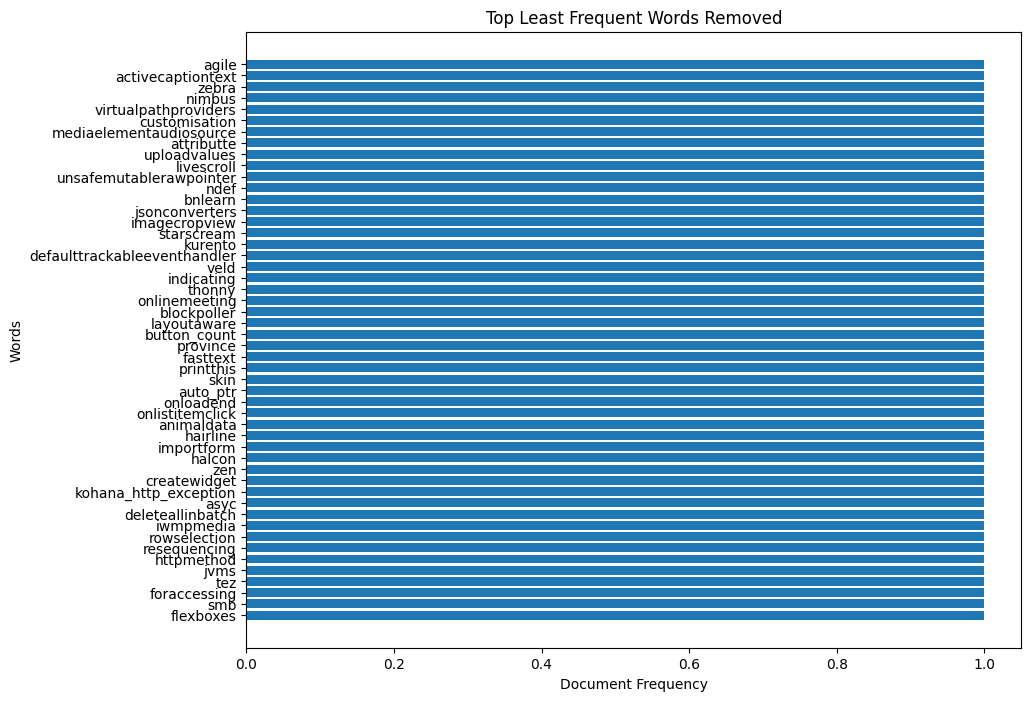

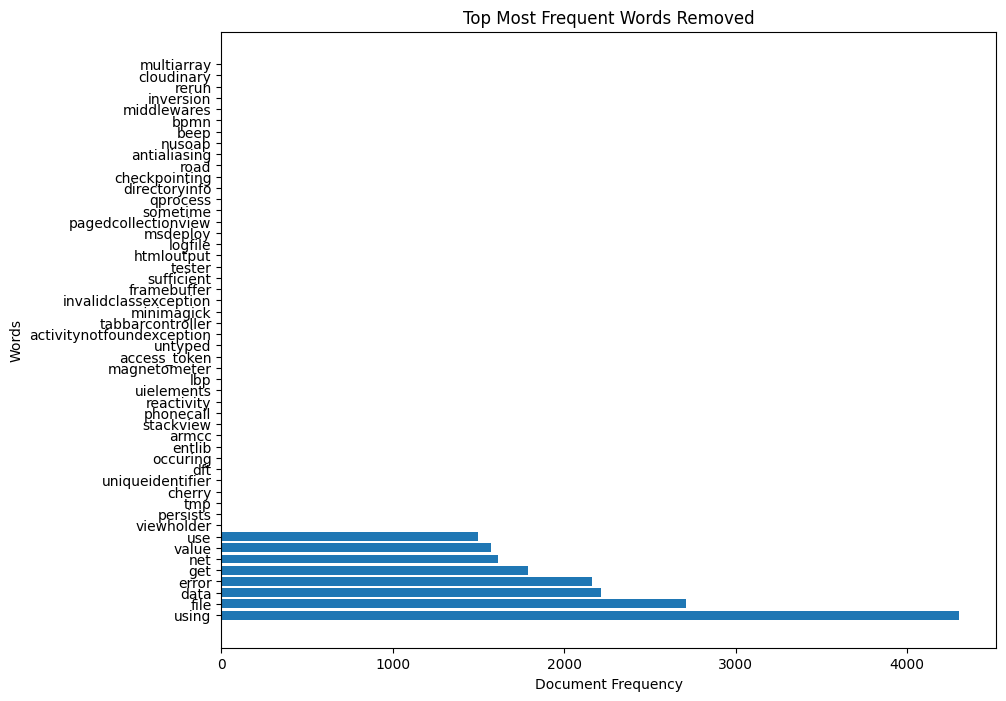

nb mots avant =  21746   nombre de mots après =  7075 ratio de réduction =  0.67


In [63]:
ratio = removed_word_frequency(50, dictionary_before, dictionary_after)

In [64]:
print("reduction ratio is ", ratio)

reduction ratio is  0.67


In [65]:
# Mise à jour de traitement de title avec le résultat de filtrage pour enelver les tokens filtrés dans Titre
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: filter_tokens(x, dictionary_after))

In [66]:
corpus.head()

,Id,Title,Body,Tags,Score,AnswerCount,Tag_token,Body_process,Body_tokens,Title_process
0,54569222,Access Denied when using Power Shell Remoting ...,<p>I want to remotely trigger some commands wi...,<windows><powershell><server><core><remoting>,2,2,"[windows, powershell, server, core, remoting]","[remotely, trigger, command, power, shell, win...","[trigger, command, shell, window, server, core...","[access, denied, power, shell, remoting, local..."
1,2131029,Preprocess SHPAML in Django's template loader?,<p>Is there any way to make Django's template ...,<python><django><templates><preprocessor><shpaml>,3,2,"[python, django, templates, preprocessor, shpaml]","[django, template, loader, template, load, dir...","[django, template, template, load, directly, v...","[django, template, loader]"
2,2131039,Writing eclipse templates,<p>I am writing django templates in Eclipse->p...,<django><eclipse><templates><eclipse-plugin><e...,7,1,"[django, eclipse, templates, eclipse-plugin, e...","[writing, django, template, eclipse, template,...","[writing, django, template, eclipse, template,...","[writing, eclipse, template]"
3,2131045,Auto update and build with eclipse and SVN,<p>every morning when i come to work i update ...,<eclipse><svn><build-process><performance><sub...,2,1,"[eclipse, svn, build-process, performance, sub...","[every, morning, come, update, source, svn, bu...","[every, come, update, source, svn, build, proc...","[auto, update, build, eclipse, svn]"
4,2131111,Use .NET in VB6 or classical ASP,"<p><strong>Duplicate of</strong> <a href=""http...",<.net><com><vb6><asp-classic><wrapper>,3,3,"[.net, com, vb6, asp-classic, wrapper]","[duplicate, calling, net, method, via, com, vi...","[duplicate, calling, net, method, via, com, vi...",[asp]


### 1.2.3 Reductions des mots (dimensions) par ACP

In [67]:
# fonction to display the curb and find the ebow
def pca_component(X_train, n_composant=200):
    
    # Créez la représentation BoW en utilisant CountVectorizer
    X_train_flat = [" ".join(doc) for doc in X_train]
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(X_train_flat)
    print("Shape of bow_matrix:", bow_matrix.shape, "nb var= ", bow_matrix.shape[1])
  
    # Appliquez l'ACP avec nb de composant 
    n = n_composant
    pca = PCA(n_components=n)
    reduced_bow = pca.fit_transform(bow_matrix.toarray())
    print("Shape of reduced_bow:", reduced_bow.shape)
          
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    
    x_list = range(1, n+1)
    list(x_list)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='.')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
    return

In [68]:
def pca_reduction_bow(X_train, n_components, top_words): 
# Créez la représentation BoW en utilisant CountVectorizer
    X_train_flat = [" ".join(doc) for doc in X_train]
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(X_train_flat)
    print("Shape of bow_matrix:", bow_matrix.shape, "nb var= ", bow_matrix.shape[1])
  
    # Appliquez l'ACP pour réduire la dimension à 1000
    n = n_components
    pca = PCA(n_components=n)
    reduced_bow = pca.fit_transform(bow_matrix.toarray())
    print("Shape of reduced_bow:", reduced_bow.shape)
    
    # Get the feature names from CountVectorizer (terms in the BoW matrix)
    feature_names = vectorizer.get_feature_names_out()

    # computes the indices of the top 'n' important terms in each principal component obtained from the PCA reduction.
    top_indices = np.argsort(pca.components_, axis=1)[:, -top_words:]

    print("Top indices:", top_indices)

    # Step 1: Create a list of tokens for each document/component (similar to X_train)
    new_list = []
    for indices in top_indices:
        terms = [feature_names[j] for j in indices]
        new_list.append(terms)

    # Step 2: Create the new dictionary using the tokens in new_list
    new_dictionary = Dictionary(new_list)    
    
    # Step 3: Display the total number of unique words in the new dictionary
    total_unique_words = len(new_dictionary)
    print("Total unique words in new dictionary:", total_unique_words)

    # Step 4: Display the first 10 words in the new dictionary
    first_10_words = list(new_dictionary.token2id.keys())[:10]
    print("First 10 words in new dictionary:", first_10_words)

    return new_dictionary

Shape of bow_matrix: (50000, 7071) nb var=  7071
Shape of reduced_bow: (50000, 7071)


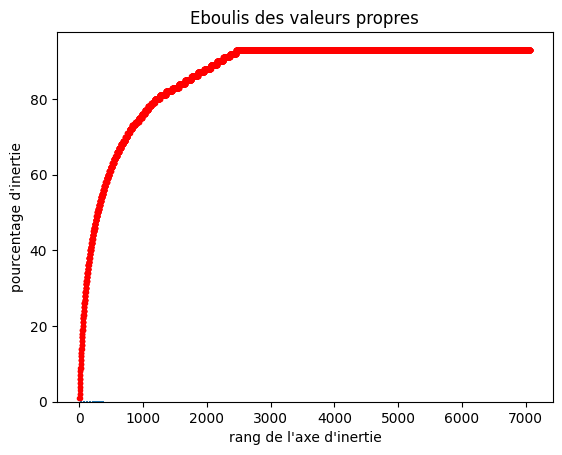

In [46]:
pca_component(corpus['Title_process', 5000])

In [69]:
dictionary_pca_title = pca_reduction_bow(corpus['Title_process'], n_components=1000, top_words=5)

Shape of bow_matrix: (50000, 7071) nb var=  7071
Shape of reduced_bow: (50000, 1000)
Top indices: [[6828  219  265 5817 5514]
 [5944  327 4062 5817 5514]
 [ 905  265 4062  219 3058]
 ...
 [1791 3440 6830 1834 4687]
 [3942 2710 6251 5504 1884]
 [3299 3277 4479 5695 6296]]
Total unique words in new dictionary: 1101
First 10 words in new dictionary: ['android', 'app', 'server', 'sql', 'web', 'array', 'object', 'string', 'class', 'java']


In [71]:
# Mise à jour de traitement de title avec le nouveau dictionnaire pca
corpus['Title_tokens'] = corpus['Title_process'].apply(lambda x: filter_tokens(x, dictionary_pca_title))

## 1.3 traitement de body

### 1.3.1 Formattage

In [40]:
# Normalisation de la casse (mise en minuscules)
corpus['Body_process'] = corpus['Body'].str.lower()

In [41]:
# Enleve les tags html et les codes
corpus['Body_process'] = corpus['Body_process'].astype(str).apply(remove_html_tags_code)

In [42]:
# Supprimer les caractères spéciaux  
# les caractères qui ne sont pas des lettres de l'alphabet (majuscules ou minuscules) y compris des chiffres sauf '-'
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))

In [43]:
# Tokenization (découpage en mots)
corpus['Body_process'] = corpus['Body_process'].apply(nltk.word_tokenize)

In [44]:
# Supprimer les mots non informatifs (stop words)
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: remove_stop_short_words(x))

In [45]:
# Lemmatisation
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: lemmatize_text(x))

In [46]:
corpus[['Body', 'Body_process']].head(3)

,Body,Body_process
0,<p>I want to remotely trigger some commands wi...,"[want, remotely, trigger, command, power, shel..."
1,<p>Is there any way to make Django's template ...,"[way, make, django, template, loader, run, tem..."
2,<p>I am writing django templates in Eclipse->p...,"[writing, django, template, eclipse, prefrence..."


### 1.3.2. Réduction de dimensions par fréquence

In [47]:
# Réduction de tokens extrèmes,  les 50 tokens les plus fréquents et les tokens présents 
# dans moins de 3 documents sont supprimés

# Create the dictionary before filtering
dictionary_before = corpora.Dictionary(corpus['Body_process'])

# Create an empty dictionary
dictionary_after = corpora.Dictionary(corpus['Body_process'])

# Filter extremes
dictionary_after.filter_extremes(no_below=4)
dictionary_after.filter_n_most_frequent(33)

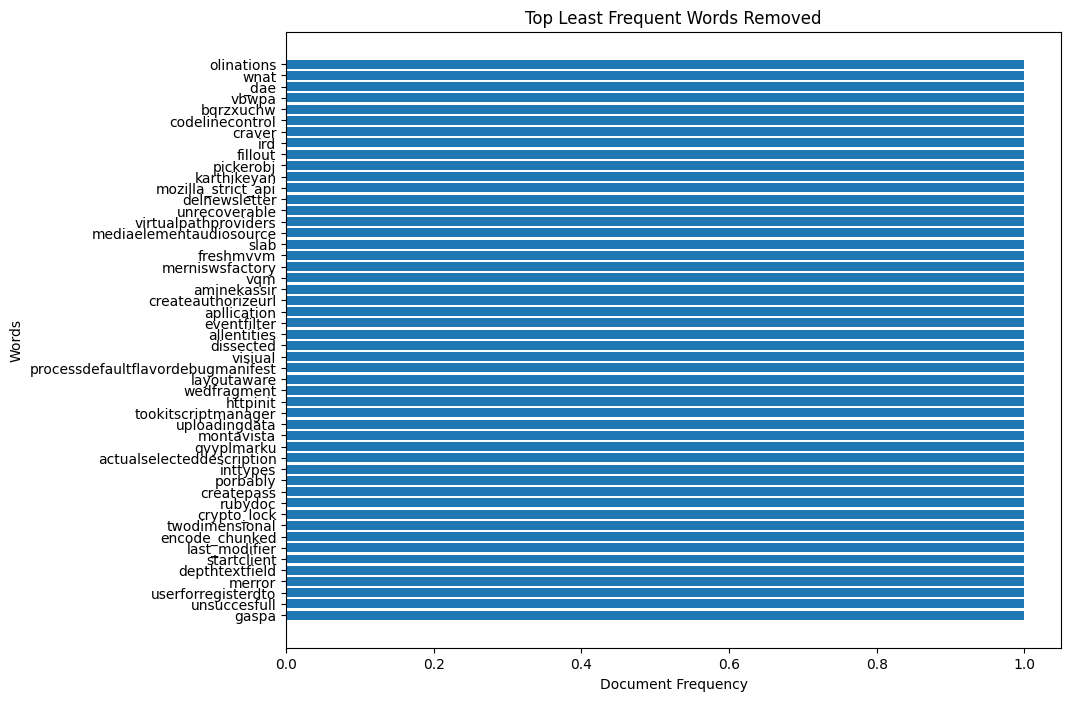

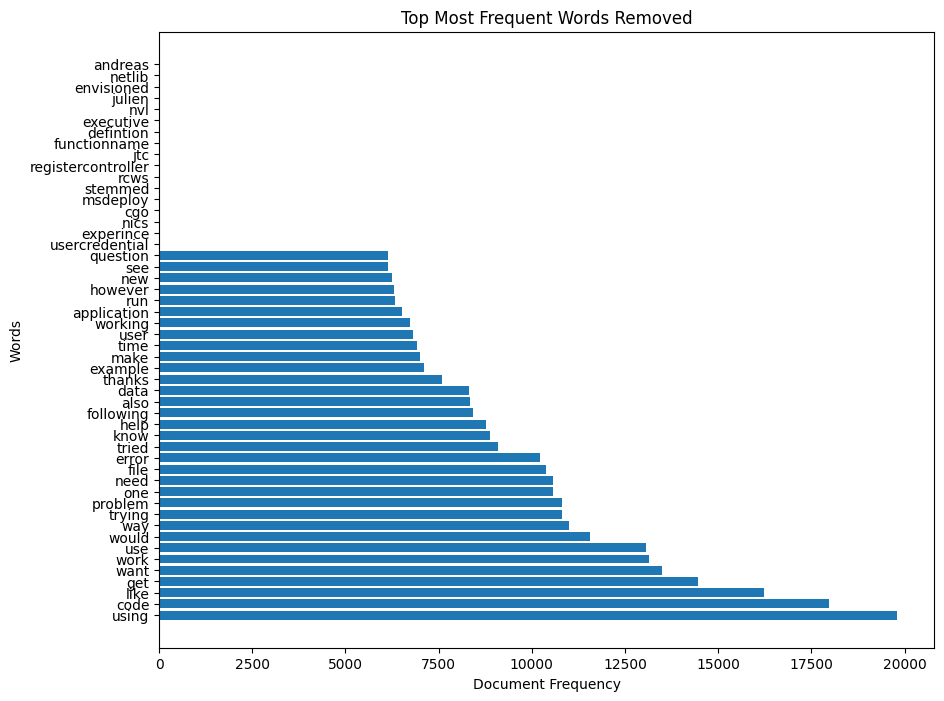

nb mots avant =  78903   nombre de mots après =  14216 ratio de réduction =  0.82


In [48]:
ratio_body = removed_word_frequency(50, dictionary_before, dictionary_after)

In [49]:
print("reduction ratio is ", ratio_body)

reduction ratio is  0.82


In [50]:
# Mise à jour de traitement de title avec le résultat de filtrage
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: filter_tokens(x, dictionary_after))

### 1.3.3. Réduction de dimension par ACP

Shape of bow_matrix: (50000, 14209) nb var=  14209
Shape of reduced_bow: (50000, 5000)


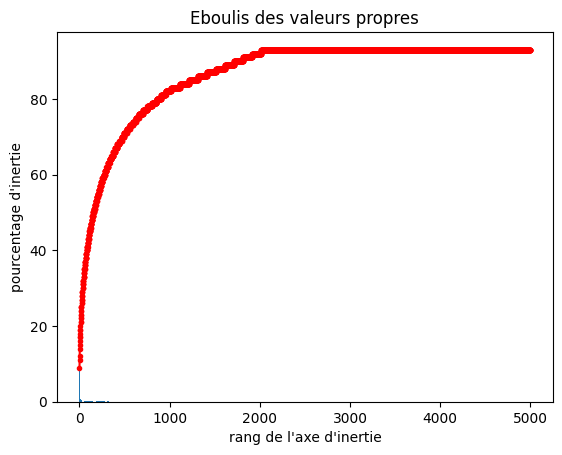

In [86]:
pca_component(corpus['Body_process'], 5000)

In [51]:
dictionary_pca_body = pca_reduction_bow(corpus['Body_process'], n_components=1500, top_words=5)

Shape of bow_matrix: (50000, 14209) nb var=  14209
Shape of reduced_bow: (50000, 1500)
Top indices: [[ 2576  1733   564  8639  6521]
 [11734 10129 12489 12462  1870]
 [13134 11734  5350 10129 12489]
 ...
 [ 4033    87  5369 12508 12059]
 [13416  8281  1083 12511  3961]
 [ 3808  7789  7077  9150  5718]]
Total unique words in new dictionary: 1582
First 10 words in new dictionary: ['apache', 'catalina', 'core', 'java', 'org', 'checking', 'reference', 'src', 'test', 'text']


In [56]:
# Mise à jour de traitement de title avec le nouveau dictionnaire pca
corpus['Body_tokens'] = corpus['Body_process'].apply(lambda x: filter_tokens(x, dictionary_pca_body))

## 1.4 traitement de tag

### 1.4.1 Formattage

Les tag sont traité pour extraire les tokens, ensuite les tokens les moins utilisés sont filtrés

In [53]:
def processTags(tags) : 
    # use regex to extract tags to list 
    regex = '<([^>]+)>'
    tagslist = re.split(regex, tags)
    # filter None values 
    tagslist_clean = filter(None, tagslist)
    # all tags to lower case 
    tagslist_lower = [ str(x).lower() for x in tagslist_clean ] 
    return tagslist_lower

In [54]:
corpus["Tag_token"] = corpus["Tags"].apply(processTags)

In [55]:
corpus[["Tags", "Tag_token"]].head(3)

,Tags,Tag_token
0,<windows><powershell><server><core><remoting>,"[windows, powershell, server, core, remoting]"
1,<python><django><templates><preprocessor><shpaml>,"[python, django, templates, preprocessor, shpaml]"
2,<django><eclipse><templates><eclipse-plugin><e...,"[django, eclipse, templates, eclipse-plugin, e..."


In [30]:
tag_count = corpus["Tag_token"].explode().value_counts()

In [31]:
len(tag_count) # number of unique tags 

18713

### 1.4.2. Réduction de dimensions par fréquence

supprimer les tag qui apparaisse moins de trois fois 

In [32]:
filtered_tags = tag_count[tag_count >= 3].index.tolist()
corpus["Tag_token"] = corpus["Tag_token"].apply(lambda tags: [tag for tag in tags if tag in filtered_tags])

In [ ]:
# Step 1: Combine all the lists of tags into a single list
all_tags = [tag for tags_list in corpus["Tag_token"] for tag in tags_list]

# Step 2: Convert the list into a set to remove duplicates
unique_tags_set = set(all_tags)

# Step 3: Calculate the number of unique words
num_unique_tags = len(unique_tags_set)

print("Number of unique words in 'Tag_token':", num_unique_tags)

### 1.4.3 Réduction de dimensions par ACP

Shape of bow_matrix: (50000, 5994) nb var=  5994
Shape of reduced_bow: (50000, 5000)


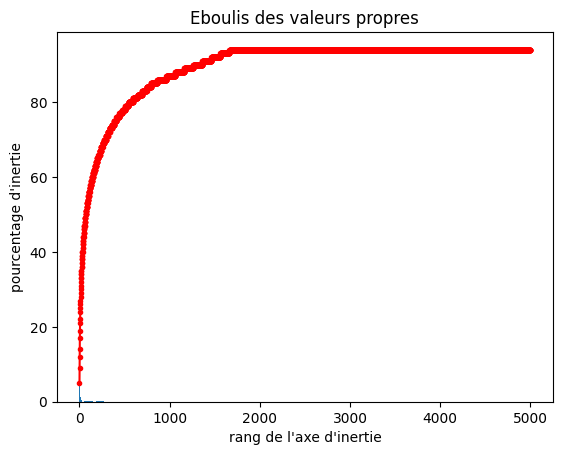

In [37]:
pca_component(corpus['Tag_token'], 5000)

In [38]:
dictionary_pca_tag = pca_reduction_bow(corpus['Tag_token'], n_components=800, top_words=5)

Shape of bow_matrix: (50000, 5994) nb var=  5994
Shape of reduced_bow: (50000, 800)
Top indices: [[5745 1064 3282  323 3336]
 [5032  323 3336 2518  206]
 [4900 2518 4642 4907 4108]
 ...
 [2733 3480 4668 3342  894]
 [1242 3055 3691 3365 3475]
 [5767 2996   91 5122  260]]
Total unique words in new dictionary: 966
First 10 words in new dictionary: ['asp', 'core', 'mvc', 'net', 'web', 'android', 'java', 'studio', 'python', 'server']


In [70]:
# Mise à jour de traitement de title avec le nouveau dictionnaire pca
corpus['Tag_token'] = corpus['Tag_token'].apply(lambda x: filter_tokens(x, dictionary_pca_tag))

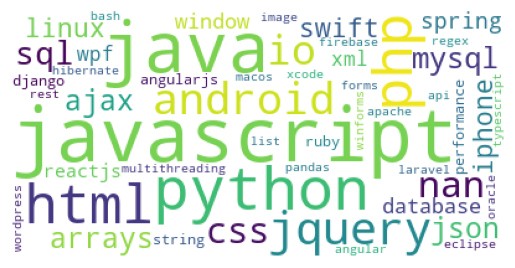

In [72]:
# Convert values to strings before joining
text = ' '.join(map(str, corpus["Tag_token"].explode()))

# Create the wordcloud object
wordcloud = WordCloud(collocations=False, background_color='white', max_words=50).generate(text)

# Display the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 1.5 enregistrement de résultat

In [73]:
corpus.columns

Index(['Id', 'Title', 'Body', 'Tags', 'Score', 'AnswerCount', 'Tag_token',
       'Body_process', 'Body_tokens', 'Title_process', 'Title_tokens'],
      dtype='object')

In [74]:
corpus[['Id', 'Title', 'Title_tokens', 'Body', 'Body_tokens', 'Tags', 'Tag_token', \
        'Score', 'AnswerCount']].to_csv('data_processed.csv', index=False)

In [75]:
corpus[['Id', 'Title', 'Title_tokens', 'Body', 'Body_tokens', 'Tags', 'Tag_token', \
        'Score', 'AnswerCount']].to_parquet('data_processed.parquet')

# 2 Extraction des features 

In [76]:
# 3 options : 
#  - fit title, transform title en bow
#  - fit title, transform title + body en bow
#  - fit title + body, transform title + body  en bow

X = corpus[['Title_tokens', 'Body_tokens']]
y = corpus['Tags']

# Split the Title_tokens into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train_title = X_train['Title_tokens']
X_test_title = X_test['Title_tokens']
X_train_body = X_train['Body_tokens']
X_test_body = X_test['Body_tokens']
print(X_train_title[:10])

39087                                  [stored, procedure]
30893                              [run, tomcat, netbeans]
45278             [show, color, view, io, navigation, bar]
16398                [form, authentication, possible, php]
13653                                    [validation, yii]
13748    [count, number, self, relationship, fit, certa...
23965                 [python, even, column, name, exists]
45552                      [regex, number, possible, text]
30219                           [removing, string, python]
24079                   [datagridview, display, datatable]
Name: Title_tokens, dtype: object


## 2.1  Bag of word

In [77]:
# Convert the list of tokenized words to a list of strings
X_train_title = [' '.join(tokens) for tokens in X_train_title]
X_train_body = [' '.join(tokens) for tokens in X_train_body]
X_test_title = [' '.join(tokens) for tokens in X_test_title]
X_test_body = [' '.join(tokens) for tokens in X_test_body]

In [78]:
print(X_train_title[:10])

['stored procedure', 'run tomcat netbeans', 'show color view io navigation bar', 'form authentication possible php', 'validation yii', 'count number self relationship fit certain criterion query', 'python even column name exists', 'regex number possible text', 'removing string python', 'datagridview display datatable']


Option 1: Fit vectorizer on X_train_title and transform X_train_title into bag-of-words representation.

In [79]:
# Fit vectorizer on X_train_title
vectorizer_title = CountVectorizer()
vectorizer_title.fit(X_train_title)

# Transform X_train_title into bag-of-words representation
bow_train_title = vectorizer_title.transform(X_train_title)
bow_test_title = vectorizer_title.transform(X_test_title)

In [80]:
feature_names = vectorizer_title.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

# Print the vocabulary (unique words)
print("Vocabulary:")
print(vectorizer_title.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

Number of features: 1101
Vocabulary:
['able', 'abstract', 'access', 'accessing', 'account', 'across', 'action', 'active', 'activity', 'adapter', 'add', 'added', 'adding', 'additional', 'address', 'admin', 'aggregate', 'ajax', 'alert', 'algorithm']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Option 2: Fit vectorizer on X_train_title, and transform X_train_title + X_train_body into bag-of-words representation.

In [81]:
# Transform X_train_title + body into bag-of-words representation
bow_train_title_body = vectorizer_title.transform(X_train_title + X_train_body)
bow_test_title_body = vectorizer_title.transform(X_test_title + X_test_body)

In [82]:
feature_names = vectorizer_title.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

# Print the vocabulary (unique words)
print("Vocabulary:")
print(vectorizer_title.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

# Print the bag-of-words representation of the test data
print("Bag-of-Words (Test):")
print(bow_test_title.toarray()[:2])

Number of features: 1101
Vocabulary:
['able', 'abstract', 'access', 'accessing', 'account', 'across', 'action', 'active', 'activity', 'adapter', 'add', 'added', 'adding', 'additional', 'address', 'admin', 'aggregate', 'ajax', 'alert', 'algorithm']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Bag-of-Words (Test):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Option 3: Fit vectorizer on X_train_title + X_train_body, and transform X_train_title + X_train_body into bag-of-words representation.

In [83]:
# Fit vectorizer on X_train_title + body
vectorizer_title_body = CountVectorizer()
vectorizer_title_body.fit(X_train_title + X_train_body)

# Transform X_train_title + body into bag-of-words representation
bow_train = vectorizer_title_body.transform(X_train_title + X_train_body)
bow_test = vectorizer_title_body.transform(X_test_title + X_test_body)

In [84]:
# Print the vocabulary (unique words)
feature_names = vectorizer_title_body.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

print("Vocabulary:")
print(vectorizer_title_body.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

# Print the bag-of-words representation of the test data
print("Bag-of-Words (Test):")
print(bow_test_title.toarray()[:2])

Number of features: 1728
Vocabulary:
['able', 'abstract', 'accept', 'access', 'accessing', 'accomplish', 'according', 'account', 'achieve', 'across', 'action', 'active', 'activity', 'actual', 'actually', 'adapter', 'add', 'added', 'adding', 'additional']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Bag-of-Words (Test):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 2.2 TF-IDF

Option 1: Fit vectorizer on X_train_title and transform X_train_title into Tfidf representation.

In [85]:
# Fit vectorizer on X_train_title
vectorizer_title_tfidf = TfidfVectorizer()
vectorizer_title_tfidf.fit(X_train_title)

# Transform X_train_title into bag-of-words representation
tfidf_train_title = vectorizer_title_tfidf.transform(X_train_title)

In [86]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title[0]

print(first_document_features)

  (0, 935)	0.6961359305669073
  (0, 743)	0.7179099986584294


In [87]:
feature_names = vectorizer_title.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title[1]

print(first_document_features)

Number of features: 1101
  (0, 993)	0.5852644560094495
  (0, 829)	0.46691159408512173
  (0, 638)	0.6629170987694114


Option 2: Fit vectorizer on X_train_title, and transform X_train_title + X_train_body into Tfidf representation.

In [88]:
# Transform X_train_title + body into bag-of-words representation
tfidf_train_title_body = vectorizer_title_tfidf.transform(X_train_title + X_train_body)

In [89]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title_body[0]

print(first_document_features)

  (0, 935)	0.6961359305669073
  (0, 743)	0.7179099986584294


In [90]:
feature_names = vectorizer_title.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title_body[2]

print(first_document_features)

Number of features: 1101
  (0, 1051)	0.36359639069067784
  (0, 880)	0.39310293906023414
  (0, 635)	0.4554231475812667
  (0, 495)	0.35054803392932854
  (0, 166)	0.4349834931043155
  (0, 76)	0.4401851170372981


Option 3: Fit vectorizer on X_train_title + X_train_body, and transform X_train_title + X_train_body into bag-of-words representation.

In [91]:
# Fit vectorizer on X_train_title + body
vectorizer_title_body_tfidf = CountVectorizer()
vectorizer_title_body_tfidf.fit(X_train_title + X_train_body)

# Transform X_train_title + body into bag-of-words representation
tfidf_train = vectorizer_title_body_tfidf.transform(X_train_body)

In [92]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train[0]

print(first_document_features)

  (0, 41)	1
  (0, 200)	1
  (0, 337)	1
  (0, 529)	1
  (0, 582)	1
  (0, 627)	1
  (0, 643)	1
  (0, 813)	1
  (0, 991)	1
  (0, 1070)	1
  (0, 1083)	1
  (0, 1164)	2
  (0, 1279)	1
  (0, 1433)	1
  (0, 1460)	1


In [75]:
feature_names = vectorizer_title_body_tfidf.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train[2]

print(first_document_features)

Number of features: 17662
  (0, 253)	1
  (0, 721)	2
  (0, 746)	1
  (0, 765)	2
  (0, 766)	1
  (0, 1341)	1
  (0, 2678)	1
  (0, 3039)	1
  (0, 3099)	6
  (0, 4019)	2
  (0, 4046)	1
  (0, 4370)	1
  (0, 4389)	1
  (0, 4577)	1
  (0, 4693)	1
  (0, 5281)	2
  (0, 5443)	1
  (0, 5825)	1
  (0, 6198)	1
  (0, 6998)	1
  (0, 7004)	1
  (0, 7119)	1
  (0, 7758)	1
  (0, 7763)	1
  (0, 7824)	1
  (0, 7841)	1
  (0, 7915)	2
  (0, 8490)	1
  (0, 8628)	1
  (0, 9149)	2
  (0, 9598)	2
  (0, 10006)	1
  (0, 10037)	1
  (0, 10259)	1
  (0, 11395)	1
  (0, 11493)	1
  (0, 11976)	1
  (0, 13402)	1
  (0, 13816)	2
  (0, 14475)	3
  (0, 14787)	2
  (0, 15481)	1
  (0, 16177)	1
  (0, 16595)	1
  (0, 16825)	9
  (0, 17428)	1
